In [6]:
!pip -q install -U \
  numpy==2.0.2 \
  pandas==2.2.2 \
  scikit-learn==1.6.1 \
  scipy==1.16.3 \
  gensim==4.4.0 \
  sentence-transformers==5.2.3 \
  torch==2.10.0

Data shape: (1000, 5)

Category counts:
category
Colon Cancer      200
Liver Cancer      200
Lung Cancer       200
Stomach Cancer    200
Thyroid Cancer    200
Name: count, dtype: int64

Label mapping (index -> class name):
0 -> Colon Cancer
1 -> Liver Cancer
2 -> Lung Cancer
3 -> Stomach Cancer
4 -> Thyroid Cancer

Number of clusters (n_clusters): 5

[BOW] raw shape: (1000, 3000) embedded shape: (1000, 50)
[TF-IDF] raw shape: (1000, 3000) embedded shape: (1000, 50)
[LDA] topic distribution shape: (1000, 20)

[Sentence-BERT] Encoding documents ...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

[Sentence-BERT] raw embedding shape: (1000, 384)
[Sentence-BERT] reduced embedding shape: (1000, 50)

[Word2Vec] Training model on tokenized texts ...
[Word2Vec] raw doc embedding shape: (1000, 200)
[Word2Vec] reduced embedding shape: (1000, 50)

Clustering with feature: BOW

=== KMeans (BOW) ===
Silhouette score: 0.15388663643123227
Cohen Kappa: 0.77625
Cluster -> True index mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(2), np.int64(2): np.int64(3), np.int64(3): np.int64(4), np.int64(4): np.int64(1)}
True index -> class name:
  0 -> Colon Cancer
  1 -> Liver Cancer
  2 -> Lung Cancer
  3 -> Stomach Cancer
  4 -> Thyroid Cancer

Confusion matrix AFTER mapping (rows=true, cols=pred):
[[154   1   1  44   0]
 [  0 129   0  71   0]
 [  1   1 162  36   0]
 [  1   2   1 196   0]
 [  0   0   0  20 180]]

=== EM_GMM (BOW) ===
Silhouette score: 0.10691920380209473
Cohen Kappa: 0.5775
Cluster -> True index mapping: {np.int64(0): np.int64(1), np.int64(1): np.int64(3), np.int64(2): np.

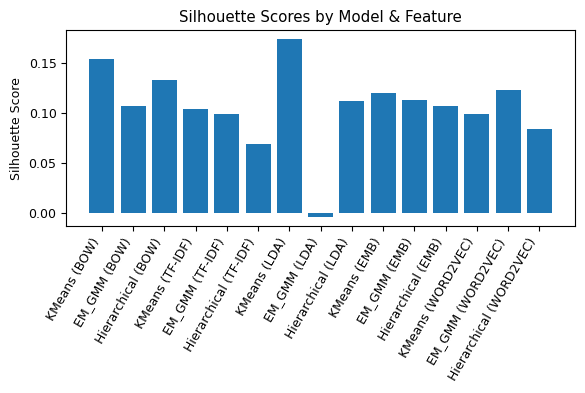

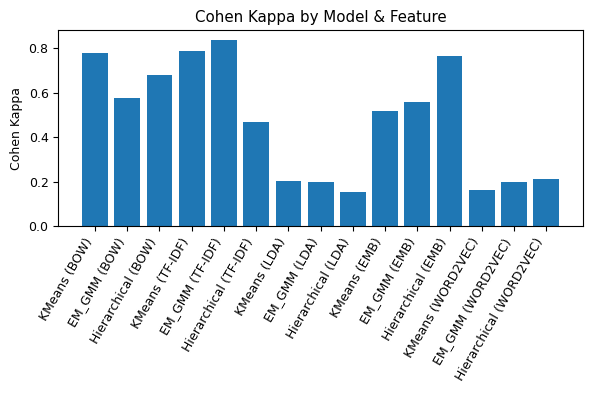

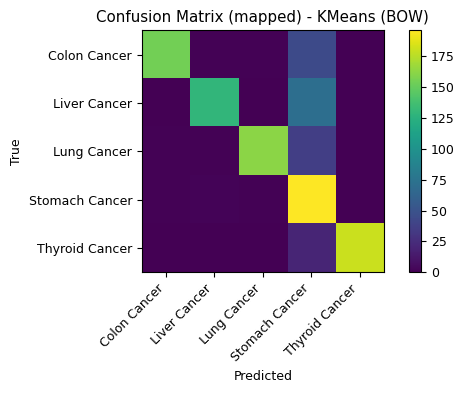

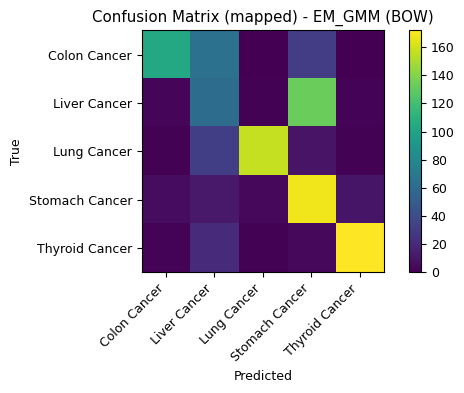

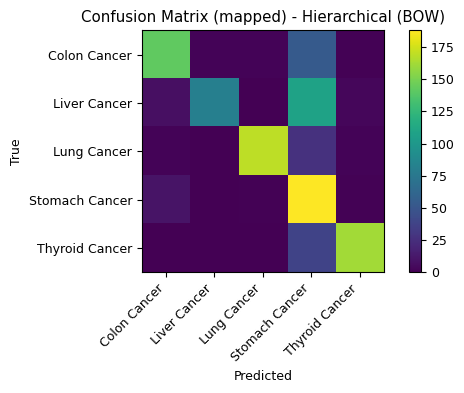

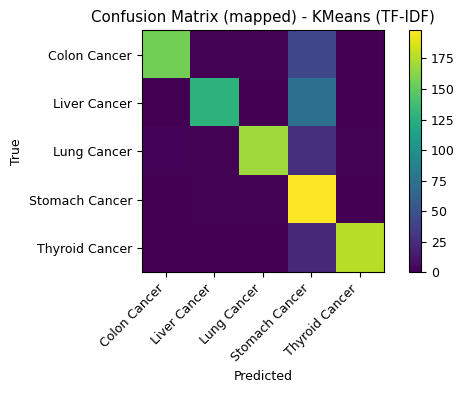

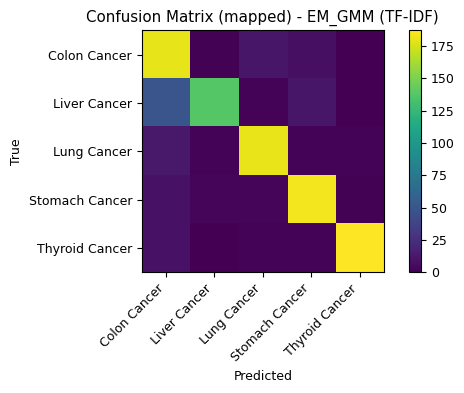

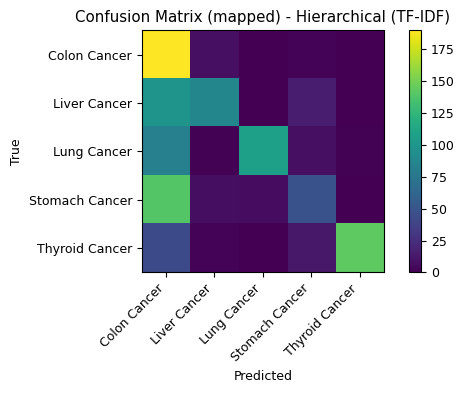

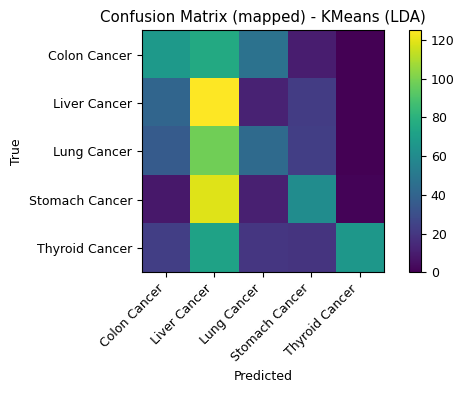

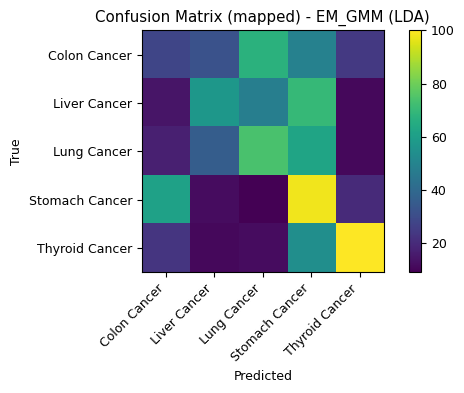

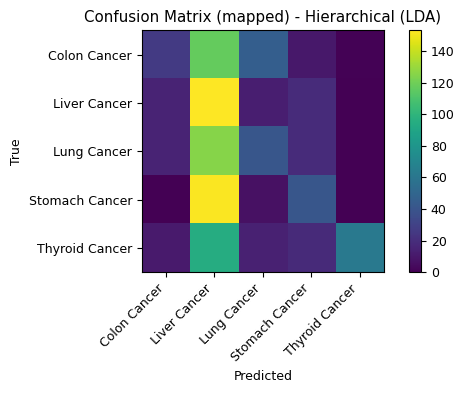

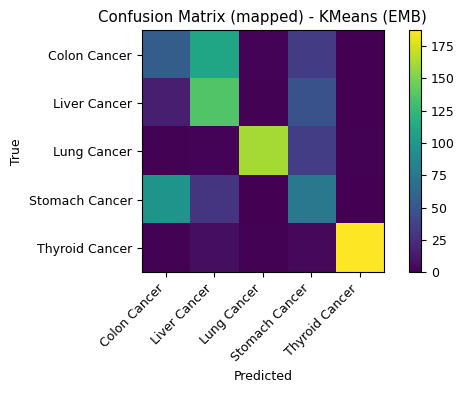

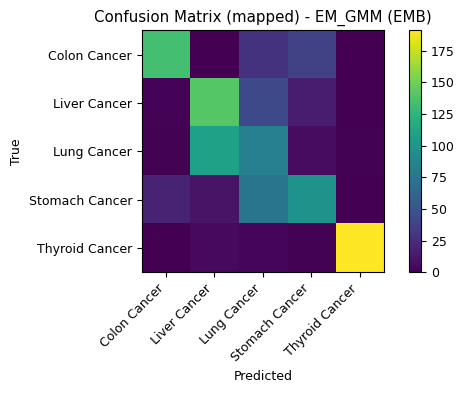

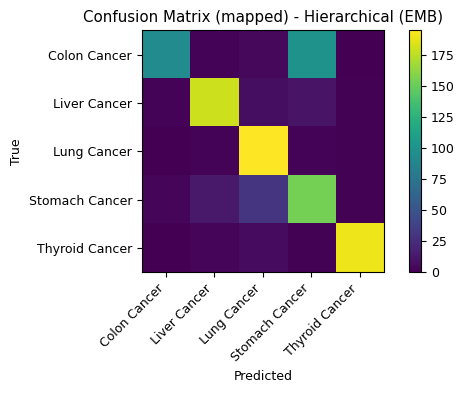

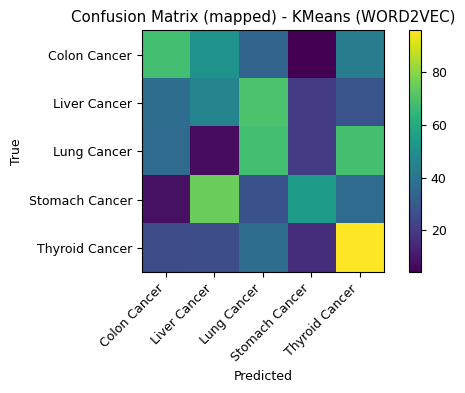

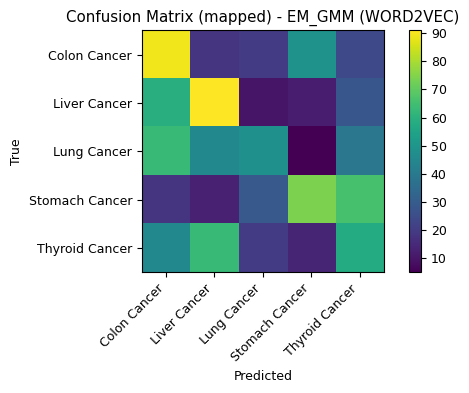

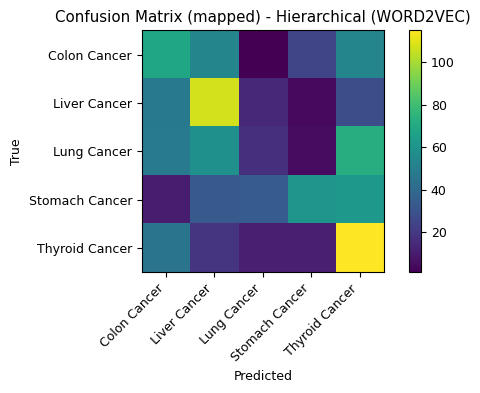

[Viz] BOW -> 2D shape: (1000, 2)
[Viz] TF-IDF -> 2D shape: (1000, 2)
[Viz] LDA -> 2D shape: (1000, 2)
[Viz] EMB -> 2D shape: (1000, 2)
[Viz] WORD2VEC -> 2D shape: (1000, 2)
Plotting 2D clusters for: KMeans (BOW) - 2D Visualization


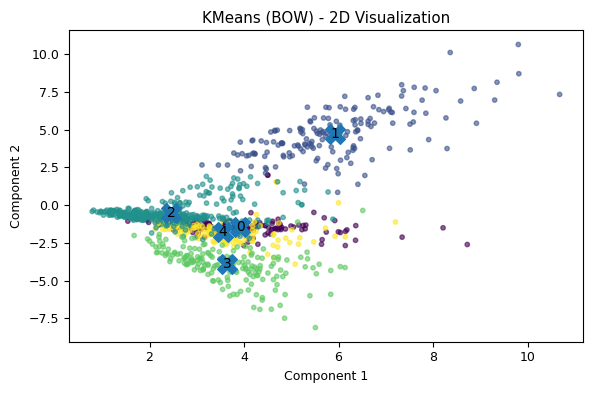

Plotting 2D clusters for: EM_GMM (BOW) - 2D Visualization


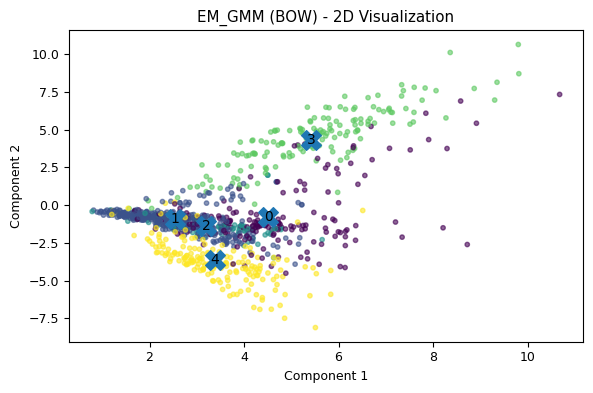

Plotting 2D clusters for: Hierarchical (BOW) - 2D Visualization


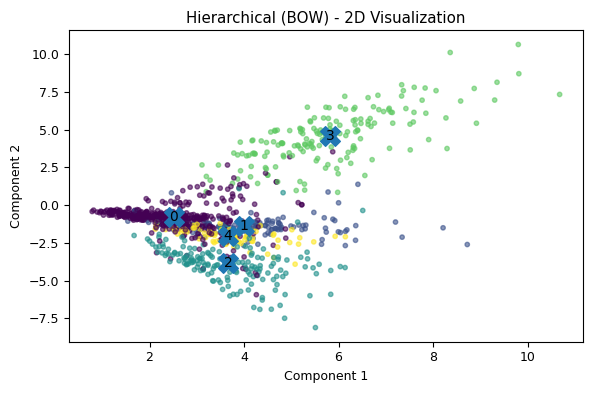

Plotting 2D clusters for: KMeans (TF-IDF) - 2D Visualization


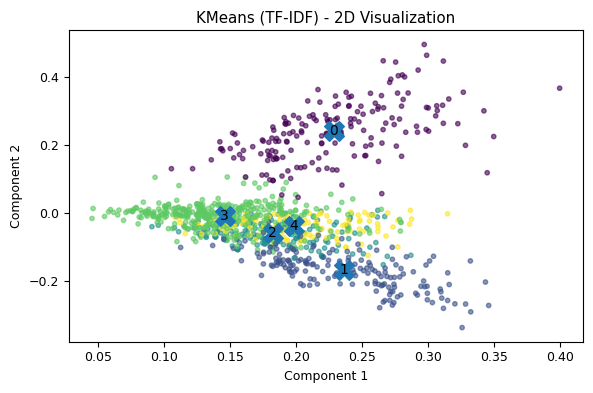

Plotting 2D clusters for: EM_GMM (TF-IDF) - 2D Visualization


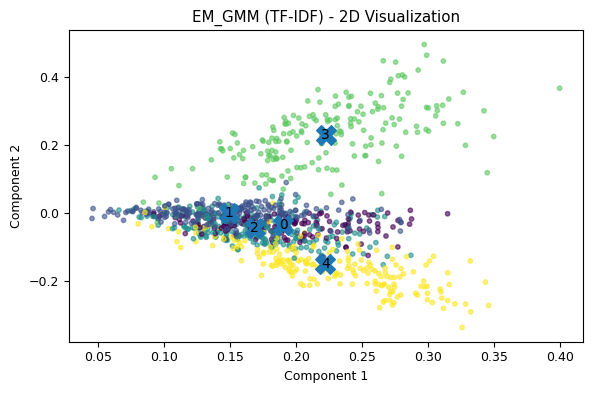

Plotting 2D clusters for: Hierarchical (TF-IDF) - 2D Visualization


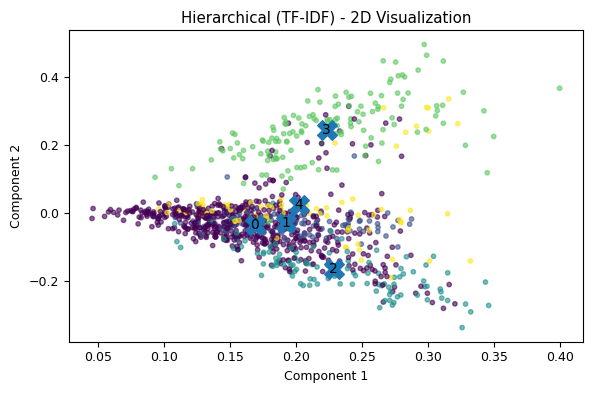

Plotting 2D clusters for: KMeans (LDA) - 2D Visualization


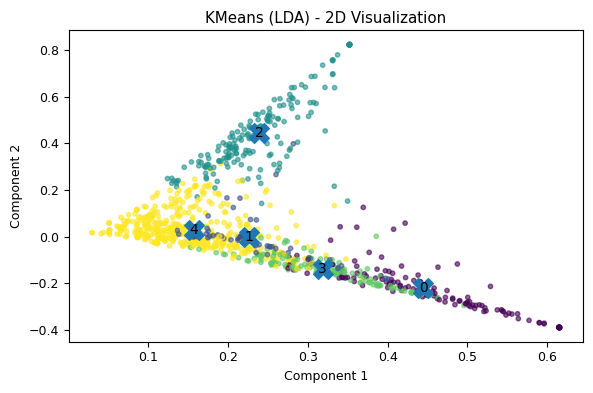

Plotting 2D clusters for: EM_GMM (LDA) - 2D Visualization


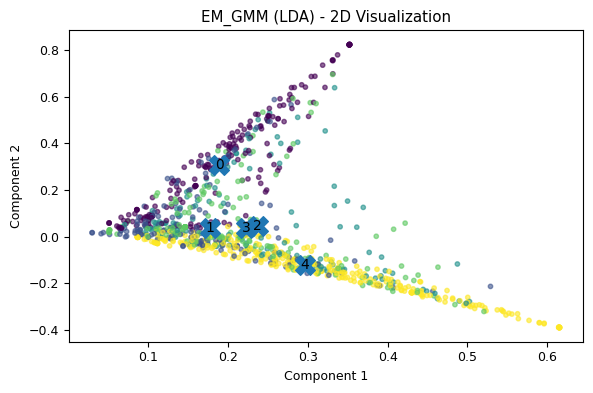

Plotting 2D clusters for: Hierarchical (LDA) - 2D Visualization


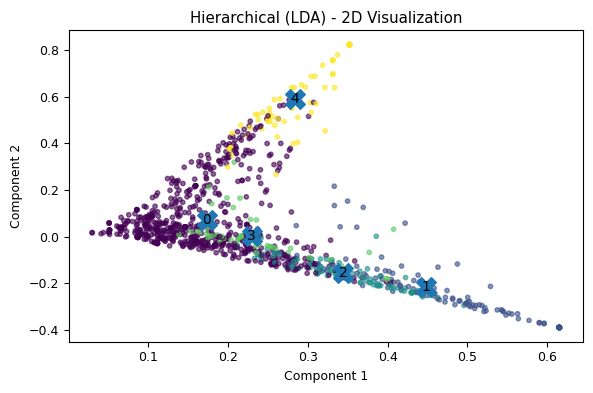

Plotting 2D clusters for: KMeans (EMB) - 2D Visualization


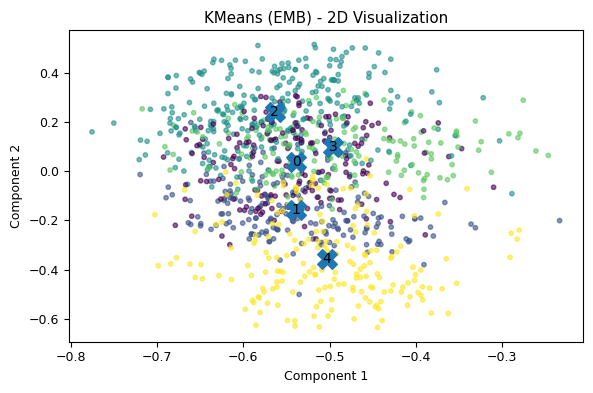

Plotting 2D clusters for: EM_GMM (EMB) - 2D Visualization


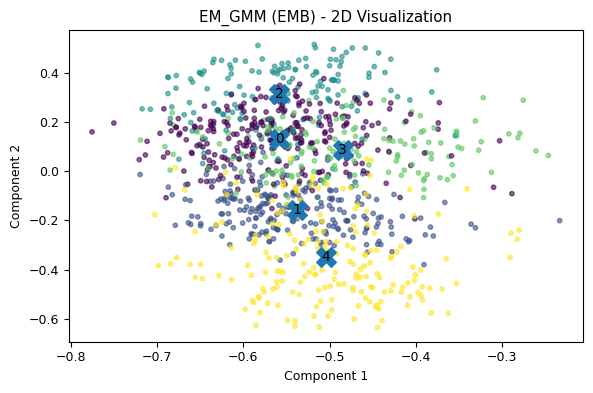

Plotting 2D clusters for: Hierarchical (EMB) - 2D Visualization


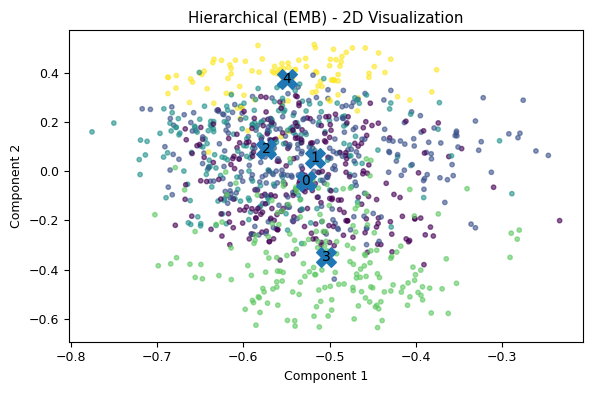

Plotting 2D clusters for: KMeans (WORD2VEC) - 2D Visualization


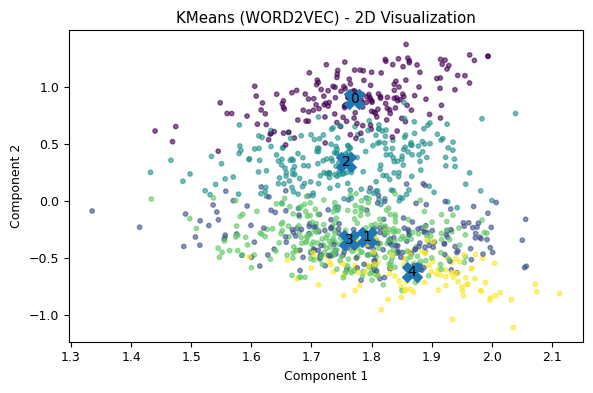

Plotting 2D clusters for: EM_GMM (WORD2VEC) - 2D Visualization


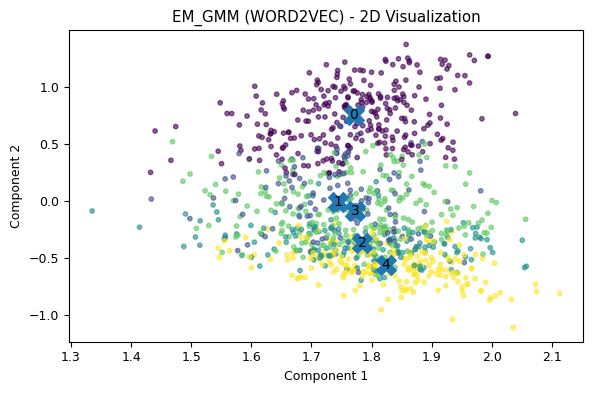

Plotting 2D clusters for: Hierarchical (WORD2VEC) - 2D Visualization


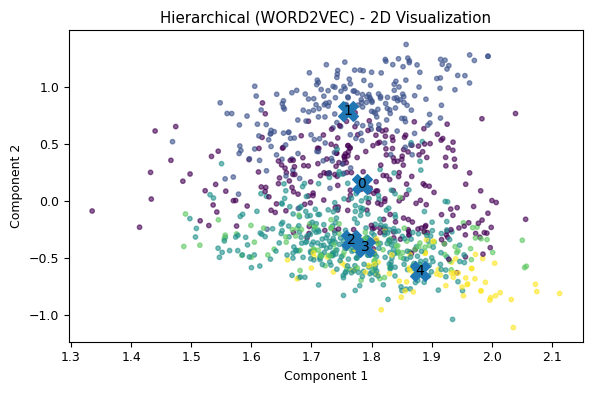

=== LDA Topic Coherence ===
UMass coherence: -2.8083239568804346
UCI coherence: -1.122017096578972
CV coherence: 0.5052983706701172

Champion model (by Kappa):
Name          EM_GMM (TF-IDF)
Model                  EM_GMM
Feature                TF-IDF
Silhouette            0.09874
Kappa                  0.8375
Name: 4, dtype: object


In [11]:
# ============================================
# Full Text Clustering Pipeline (with Word2Vec)
# Features: BOW, TF-IDF, LDA, Sentence-BERT, Word2Vec
# Algorithms: KMeans, EM(GMM), Hierarchical
# Metrics: Silhouette, Cohen Kappa
# Viz: bar charts, confusion matrices, 2D scatter plots
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, confusion_matrix, cohen_kappa_score
from scipy.optimize import linear_sum_assignment

# Embeddings & topic coherence tools
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 9

# ============================================
# 1. Load data
# ============================================

DATA_PATH = "processed_data.csv"   # 你之前用的同名 csv
TEXT_COLUMN = "text_clean"
LABEL_COLUMN = "category"

df = pd.read_csv(DATA_PATH)

print("Data shape:", df.shape)
print("\nCategory counts:")
print(df[LABEL_COLUMN].value_counts())

texts = df[TEXT_COLUMN].astype(str).tolist()
true_labels_str = df[LABEL_COLUMN].astype(str).tolist()

# True labels -> 0..4
le = LabelEncoder()
y_true = le.fit_transform(true_labels_str)

print("\nLabel mapping (index -> class name):")
for i, c in enumerate(le.classes_):
    print(f"{i} -> {c}")

n_clusters = len(le.classes_)
print("\nNumber of clusters (n_clusters):", n_clusters)

# Tokenized texts (for Word2Vec, LDA coherence, etc.)
texts_tokenized = [t.split() for t in texts]


# ============================================
# 2. Feature Engineering
#    - BOW + SVD
#    - TF-IDF + SVD
#    - LDA (topic proportions)
#    - Sentence-BERT (doc embeddings + SVD)
#    - Word2Vec (average word embeddings + SVD)
# ============================================

max_features = 3000
svd_dim = 50
lda_topics = 20

# ----- 2.1 BOW -----
bow_vectorizer = CountVectorizer(max_features=max_features)
X_bow = bow_vectorizer.fit_transform(texts)

svd_bow = TruncatedSVD(n_components=svd_dim, random_state=42)
X_bow_emb = svd_bow.fit_transform(X_bow)

print("\n[BOW] raw shape:", X_bow.shape, "embedded shape:", X_bow_emb.shape)

# ----- 2.2 TF-IDF -----
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
X_tfidf = tfidf_vectorizer.fit_transform(texts)

svd_tfidf = TruncatedSVD(n_components=svd_dim, random_state=42)
X_tfidf_emb = svd_tfidf.fit_transform(X_tfidf)

print("[TF-IDF] raw shape:", X_tfidf.shape, "embedded shape:", X_tfidf_emb.shape)

# ----- 2.3 LDA (on BOW) -----
lda = LatentDirichletAllocation(
    n_components=lda_topics,
    random_state=42,
    learning_method="batch"
)
X_lda = lda.fit_transform(X_bow)
print("[LDA] topic distribution shape:", X_lda.shape)

# ----- 2.4 Sentence-BERT embeddings -----
print("\n[Sentence-BERT] Encoding documents ...")
embed_model = SentenceTransformer("all-MiniLM-L6-v2")
X_embed_raw = embed_model.encode(texts, show_progress_bar=True)
print("[Sentence-BERT] raw embedding shape:", X_embed_raw.shape)

svd_emb = TruncatedSVD(n_components=svd_dim, random_state=42)
X_emb = svd_emb.fit_transform(X_embed_raw)
print("[Sentence-BERT] reduced embedding shape:", X_emb.shape)

# ----- 2.5 Word2Vec (classic word-embedding) -----
print("\n[Word2Vec] Training model on tokenized texts ...")
w2v_dim = 200
w2v_model = Word2Vec(
    sentences=texts_tokenized,
    vector_size=w2v_dim,
    window=5,
    min_count=1,
    workers=4,
    sg=1,
    epochs=20,
)

def document_vector(tokens):
    """Average Word2Vec vectors for tokens in one document."""
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    if len(vecs) == 0:
        return np.zeros(w2v_dim)
    return np.mean(vecs, axis=0)

X_w2v_raw = np.vstack([document_vector(toks) for toks in texts_tokenized])
print("[Word2Vec] raw doc embedding shape:", X_w2v_raw.shape)

svd_w2v = TruncatedSVD(n_components=svd_dim, random_state=42)
X_w2v = svd_w2v.fit_transform(X_w2v_raw)
print("[Word2Vec] reduced embedding shape:", X_w2v.shape)


# ============================================
# 3. Kappa with optimal mapping via confusion matrix
# ============================================

def compute_kappa_with_optimal_mapping(y_true, cluster_labels):
    cm_raw = confusion_matrix(y_true, cluster_labels)

    # maximize diagonal -> minimize negative counts
    cost_matrix = -cm_raw.T
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    mapping = {cluster_id: true_label_idx
               for cluster_id, true_label_idx in zip(row_ind, col_ind)}

    mapped_labels = np.vectorize(mapping.get)(cluster_labels)
    kappa = cohen_kappa_score(y_true, mapped_labels)
    cm_mapped = confusion_matrix(y_true, mapped_labels)

    return kappa, mapping, cm_raw, cm_mapped, mapped_labels


def evaluate_clustering(model_name, feature_name, y_true, X_emb, cluster_labels):
    sil = silhouette_score(X_emb, cluster_labels)
    kappa, mapping, cm_raw, cm_mapped, mapped_labels = compute_kappa_with_optimal_mapping(
        y_true, cluster_labels
    )

    full_name = f"{model_name} ({feature_name})"
    print(f"\n=== {full_name} ===")
    print("Silhouette score:", sil)
    print("Cohen Kappa:", kappa)
    print("Cluster -> True index mapping:", mapping)
    print("True index -> class name:")
    for i, c in enumerate(le.classes_):
        print(f"  {i} -> {c}")
    print("\nConfusion matrix AFTER mapping (rows=true, cols=pred):")
    print(cm_mapped)

    return {
        "Model": model_name,
        "Feature": feature_name,
        "Name": full_name,
        "Silhouette": sil,
        "Kappa": kappa,
        "Mapping": mapping,
        "CM_raw": cm_raw,
        "CM_mapped": cm_mapped,
        "cluster_labels": cluster_labels,
        "mapped_labels": mapped_labels,
    }


# ============================================
# 4. Clustering runners
# ============================================

def run_kmeans(X, n_clusters, random_state=42):
    km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    return km.fit_predict(X)

def run_gmm(X, n_clusters, random_state=42):
    gmm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gmm.fit(X)
    return gmm.predict(X)

def run_agg(X, n_clusters):
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    return agg.fit_predict(X)


# ============================================
# 5. Run all feature × algorithm combinations
# ============================================

features = {
    "BOW": X_bow_emb,
    "TF-IDF": X_tfidf_emb,
    "LDA": X_lda,
    "EMB": X_emb,          # Sentence-BERT
    "WORD2VEC": X_w2v,     # classic word-embedding (average Word2Vec)
}

algorithms = {
    "KMeans": run_kmeans,
    "EM_GMM": run_gmm,
    "Hierarchical": run_agg,
}

results = []

for feat_name, X_feat in features.items():
    print("\n" + "="*30)
    print(f"Clustering with feature: {feat_name}")
    print("="*30)
    for algo_name, algo_func in algorithms.items():
        labels = algo_func(X_feat, n_clusters)
        res = evaluate_clustering(algo_name, feat_name, y_true, X_feat, labels)
        results.append(res)


# ============================================
# 6. Summary metrics + bar plots
# ============================================

metrics_df = pd.DataFrame(
    [{
        "Name": r["Name"],
        "Model": r["Model"],
        "Feature": r["Feature"],
        "Silhouette": r["Silhouette"],
        "Kappa": r["Kappa"],
    } for r in results]
)

print("\n=== Summary metrics (all models) ===")
print(metrics_df)

# Silhouette bar chart
plt.figure()
plt.bar(metrics_df["Name"], metrics_df["Silhouette"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores by Model & Feature")
plt.tight_layout()
plt.show()

# Kappa bar chart
plt.figure()
plt.bar(metrics_df["Name"], metrics_df["Kappa"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Cohen Kappa")
plt.title("Cohen Kappa by Model & Feature")
plt.tight_layout()
plt.show()


# ============================================
# 7. Confusion matrix heatmaps for all models
# ============================================

def plot_confusion_matrix(cm, title, class_names):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

class_names = list(le.classes_)

for r in results:
    title = f"Confusion Matrix (mapped) - {r['Name']}"
    plot_confusion_matrix(r["CM_mapped"], title, class_names)


# ============================================
# 8. 2D Visualization for all models (SVD to 2D)
# ============================================

from sklearn.decomposition import TruncatedSVD as TSVD2

viz_embeddings = {}
for feat_name, X_feat in features.items():
    svd_vis = TSVD2(n_components=2, random_state=42)
    X_2d = svd_vis.fit_transform(X_feat)
    viz_embeddings[feat_name] = X_2d
    print(f"[Viz] {feat_name} -> 2D shape:", X_2d.shape)

def plot_2d_clusters(X_2d, labels, title):
    plt.figure()
    plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, alpha=0.6, c=labels)
    unique_labels = np.unique(labels)
    centers = []
    for k in unique_labels:
        centers.append(X_2d[labels == k].mean(axis=0))
    centers = np.vstack(centers)
    plt.scatter(centers[:, 0], centers[:, 1], s=200, marker="X")
    for idx, (x, y) in enumerate(centers):
        plt.text(x, y, str(idx), fontsize=10, ha="center", va="center")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()

for r in results:
    feat_name = r["Feature"]
    X_2d = viz_embeddings[feat_name]
    labels = r["cluster_labels"]
    title = f"{r['Name']} - 2D Visualization"
    print(f"Plotting 2D clusters for: {title}")
    plot_2d_clusters(X_2d, labels, title)


# ============================================
# 9. LDA topic coherence
# ============================================
!pip install gensim

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Use the same tokenization as BOW
texts_tokenized = [t.split() for t in texts]

# Create dictionary and corpus for gensim
dictionary = Dictionary(texts_tokenized)
corpus = [dictionary.doc2bow(t) for t in texts_tokenized]

# Convert your sklearn LDA to a gensim-compatible topic-word format
# Instead of passing the raw probability distribution, we extract the top words for each topic.

# Get feature names (words) from the CountVectorizer that was used for BOW
feature_names = bow_vectorizer.get_feature_names_out()

# Define how many top words to consider for each topic
num_top_words = 10 # You can adjust this number based on your needs

topics_for_gensim = []
for topic_weights in lda.components_:
    # Get the indices of words with the highest weights for the current topic
    top_features_indices = topic_weights.argsort()[:-num_top_words - 1:-1]
    # Get the actual words using these indices
    top_words = [feature_names[i] for i in top_features_indices]
    topics_for_gensim.append(top_words)

# Calculate three types of coherence
coh_umass = CoherenceModel(
    topics=topics_for_gensim, # Use the correctly formatted topics
    texts=texts_tokenized,
    dictionary=dictionary,
    coherence='u_mass'
).get_coherence()

coh_uci = CoherenceModel(
    topics=topics_for_gensim, # Use the correctly formatted topics
    texts=texts_tokenized,
    dictionary=dictionary,
    coherence='c_uci'
).get_coherence()

coh_cv = CoherenceModel(
    topics=topics_for_gensim, # Use the correctly formatted topics
    texts=texts_tokenized,
    dictionary=dictionary,
    coherence='c_v'
).get_coherence()

print("=== LDA Topic Coherence ===")
print("UMass coherence:", coh_umass)
print("UCI coherence:", coh_uci)
print("CV coherence:", coh_cv)

# ============================================
# 10. Champion model by Kappa
# ============================================

champ_idx = metrics_df["Kappa"].idxmax()
champ_row = metrics_df.loc[champ_idx]
print("\n===============================")
print("Champion model (by Kappa):")
print(champ_row)
print("===============================")



Champion model (by Kappa):
Name          EM_GMM (TF-IDF)
Model                  EM_GMM
Feature                TF-IDF
Silhouette            0.09874
Kappa                  0.8375
Name: 4, dtype: object

[B1] Overall Error Rate: 0.130  ( 130 / 1000 )

[B2] Error Rate by True Class:
true_name
Liver Cancer      0.310
Colon Cancer      0.100
Lung Cancer       0.095
Stomach Cancer    0.080
Thyroid Cancer    0.065
Name: is_error, dtype: float64 

[B3] Confusion Table (rows=true, cols=pred):
pred_name       Colon Cancer  Liver Cancer  Lung Cancer  Stomach Cancer  \
true_name                                                                 
Colon Cancer             180             1           11               8   
Liver Cancer              49           138            2              11   
Lung Cancer               13             2          181               2   
Stomach Cancer             9             3            3             184   
Thyroid Cancer             9             0            2      

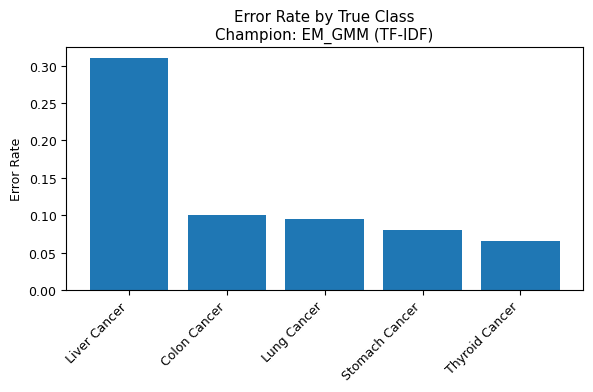

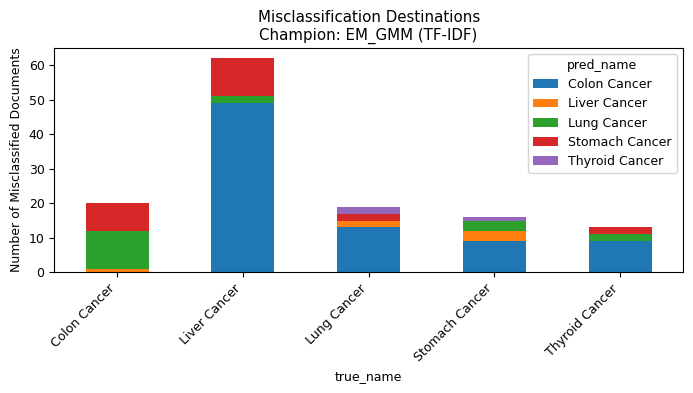


[Cluster Keyword Analysis] Top TF-IDF Words per Mapped Class:

- Class: Colon Cancer  |  cluster_id: 2
  Top words: ['colon', 'cell', 'colorectal', 'hcc', 'expression', 'survival', 'use', 'stage', 'gene', 'rectal', 'assay', 'risk', 'carcinoma', 'effect', 'immune']

- Class: Liver Cancer  |  cluster_id: 0
  Top words: ['liver', 'metastasis', 'cell', 'hcc', 'use', 'primary', 'risk', 'model', 'hepatitis', 'factor', 'colorectal', 'hepatic', 'burden', 'hepatocellular', 'resection']

- Class: Lung Cancer  |  cluster_id: 4
  Top words: ['lung', 'cell', 'risk', 'small', 'use', 'screen', 'mortality', 'non', 'adenocarcinoma', 'expression', 'gene', 'nsclc', 'egfr', 'early', 'association']

- Class: Stomach Cancer  |  cluster_id: 1
  Top words: ['stomach', 'gastric', 'rate', 'incidence', 'gastrectomy', 'year', 'mortality', 'age', 'risk', 'group', 'use', 'population', 'gastrointestinal', 'among', 'early']

- Class: Thyroid Cancer  |  cluster_id: 3
  Top words: ['thyroid', 'nodule', 'papillary', 'r

In [12]:
# ==========================================================
# ERROR ANALYSIS PIPELINE FOR CHAMPION CLUSTERING MODEL
# ==========================================================
# This module performs structured post-hoc error analysis
# for the selected champion model (by highest Kappa score).
# It includes:
#   1. Champion model selection
#   2. Overall error computation
#   3. Class-wise error distribution
#   4. Confusion structure analysis
#   5. Visualization of misclassification patterns
#   6. Cluster-level keyword interpretation
#   7. Attractor cluster investigation
#   8. Representative error examples
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------------------------------------
# 1. Utility Function: Retrieve Model Results by Name
# ----------------------------------------------------------
def get_result_by_name(results, name):
    for r in results:
        if r["Name"] == name:
            return r
    raise ValueError(f"Result with Name='{name}' not found.")


# ----------------------------------------------------------
# 2. Utility Function: Extract Top TF-IDF Words for Cluster
# ----------------------------------------------------------
def top_words_from_tfidf_cluster(X_tfidf_raw, vocab, mask, topk=15):
    mean_vec = X_tfidf_raw[mask].mean(axis=0).A1
    top_idx = mean_vec.argsort()[::-1][:topk]
    return vocab[top_idx], mean_vec[top_idx]


# ----------------------------------------------------------
# 3. Main Procedure: Structured Error Analysis
# ----------------------------------------------------------
def run_error_analysis_auto(df, TEXT_COLUMN, LABEL_COLUMN_STR, le, y_true,
                            results, metrics_df, X_tfidf_raw, tfidf_vectorizer,
                            topk_words=15, n_examples=5):

    # ------------------------------------------------------
    # 3.1 Champion Model Selection (Highest Kappa)
    # ------------------------------------------------------
    champ_idx = metrics_df["Kappa"].idxmax()
    champ_row = metrics_df.loc[champ_idx]
    champ_name = champ_row["Name"]
    champ_res = get_result_by_name(results, champ_name)

    print("\n===============================")
    print("Champion model (by Kappa):")
    print(champ_row)
    print("===============================\n")

    # ------------------------------------------------------
    # 3.2 Construct Prediction and Error DataFrame
    # ------------------------------------------------------
    y_pred_mapped = champ_res["mapped_labels"]
    cluster_labels = champ_res["cluster_labels"]
    mapping = champ_res["Mapping"]  # cluster_id -> true_idx
    class_names = list(le.classes_)

    df_err = df.copy()
    df_err["true_idx"] = y_true
    df_err["pred_idx"] = y_pred_mapped
    df_err["true_name"] = [class_names[i] for i in y_true]
    df_err["pred_name"] = [class_names[i] for i in y_pred_mapped]
    df_err["cluster_id"] = cluster_labels
    df_err["is_error"] = (df_err["true_idx"] != df_err["pred_idx"])

    # ------------------------------------------------------
    # 3.3 Overall Error Rate Computation
    # ------------------------------------------------------
    err_rate = df_err["is_error"].mean()
    err_count = int(df_err["is_error"].sum())
    print(f"[B1] Overall Error Rate: {err_rate:.3f}  ( {err_count} / {len(df_err)} )\n")

    # ------------------------------------------------------
    # 3.4 Class-wise Error Rate Distribution
    # ------------------------------------------------------
    err_by_class = df_err.groupby("true_name")["is_error"].mean().sort_values(ascending=False)
    print("[B2] Error Rate by True Class:")
    print(err_by_class, "\n")

    # ------------------------------------------------------
    # 3.5 Confusion Matrix Construction
    # ------------------------------------------------------
    conf_table = pd.crosstab(df_err["true_name"], df_err["pred_name"])
    print("[B3] Confusion Table (rows=true, cols=pred):")
    print(conf_table, "\n")

    # ------------------------------------------------------
    # 3.6 Top Misclassification Pairs (Error Only)
    # ------------------------------------------------------
    pairs = (df_err[df_err["is_error"]]
             .groupby(["true_name", "pred_name"])
             .size()
             .sort_values(ascending=False))
    print("[C] Top Confusion Pairs (Errors Only):")
    print(pairs.head(10), "\n")

    # ------------------------------------------------------
    # 3.7 Visualization: Class-wise Error Rate
    # ------------------------------------------------------
    plt.figure(figsize=(6,4))
    plt.bar(err_by_class.index, err_by_class.values)
    plt.ylabel("Error Rate")
    plt.title(f"Error Rate by True Class\nChampion: {champ_name}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    # 3.8 Visualization: Misclassification Flow (Stacked Bar)
    # ------------------------------------------------------
    err_only = df_err[df_err["is_error"]]
    if len(err_only) > 0:
        mis_dist = pd.crosstab(err_only["true_name"], err_only["pred_name"])
        mis_dist.plot(kind="bar", stacked=True, figsize=(7,4))
        plt.ylabel("Number of Misclassified Documents")
        plt.title(f"Misclassification Destinations\nChampion: {champ_name}")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    # ------------------------------------------------------
    # 3.9 Cluster-Level Keyword Analysis (TF-IDF)
    # ------------------------------------------------------
    vocab = np.array(tfidf_vectorizer.get_feature_names_out())

    print("\n[Cluster Keyword Analysis] Top TF-IDF Words per Mapped Class:")

    for true_idx, true_name in enumerate(class_names):
        cluster_id = [cid for cid, tidx in mapping.items() if tidx == true_idx][0]
        mask = (cluster_labels == cluster_id)
        top_words, _ = top_words_from_tfidf_cluster(
            X_tfidf_raw, vocab, mask, topk=topk_words
        )
        print(f"\n- Class: {true_name}  |  cluster_id: {cluster_id}")
        print("  Top words:", list(top_words))

    # ------------------------------------------------------
    # 3.10 Attractor Cluster Identification
    # ------------------------------------------------------
    if len(err_only) > 0:
        attractor = err_only["pred_name"].value_counts().idxmax()
        attractor_idx = class_names.index(attractor)
        attractor_cluster = [cid for cid, tidx in mapping.items() if tidx == attractor_idx][0]

        print("\n[Attractor Analysis]")
        print("Predicted Label Receiving Most Errors:", attractor)
        print("Corresponding cluster_id:", attractor_cluster)

        mask_attr = (cluster_labels == attractor_cluster)
        top_words_attr, _ = top_words_from_tfidf_cluster(
            X_tfidf_raw, vocab, mask_attr, topk=topk_words
        )
        print("Top words in Attractor Cluster:", list(top_words_attr))

    # ------------------------------------------------------
    # 3.11 Representative Error Examples
    # ------------------------------------------------------
    if len(pairs) > 0:
        true_p, pred_p = pairs.index[0]
        print(f"\n[Representative Examples] Most Common Confusion:")
        print(f"TRUE={true_p}  ->  PRED={pred_p}")

        ex = df_err[(df_err["true_name"]==true_p) &
                    (df_err["pred_name"]==pred_p)].head(n_examples)

        for _, row in ex.iterrows():
            print("\n--- Example ---")
            print("TRUE:", row["true_name"],
                  "PRED:", row["pred_name"],
                  "cluster_id:", row["cluster_id"])
            snippet = str(row[TEXT_COLUMN])[:600]
            print("TEXT (clean snippet):", snippet,
                  "..." if len(snippet)==600 else "")

    # ------------------------------------------------------
    # 3.12 Return Analysis Outputs
    # ------------------------------------------------------
    return {
        "champ_row": champ_row,
        "champ_res": champ_res,
        "df_err": df_err,
        "err_by_class": err_by_class,
        "conf_table": conf_table,
        "pairs": pairs
    }


# ----------------------------------------------------------
# 4. Execute Error Analysis
# ----------------------------------------------------------
analysis_out = run_error_analysis_auto(
    df=df,
    TEXT_COLUMN=TEXT_COLUMN,
    LABEL_COLUMN_STR=LABEL_COLUMN,
    le=le,
    y_true=y_true,
    results=results,
    metrics_df=metrics_df,
    X_tfidf_raw=X_tfidf,
    tfidf_vectorizer=tfidf_vectorizer,
    topk_words=15,
    n_examples=5
)